In [1]:
import json
import random
import sys
import numpy as np
import networkx as nx
from PIL import Image, ImageDraw, ImageColor
from sklearn import neighbors
from tqdm import tqdm
import utm
import matplotlib.pyplot as plt
from geopy.distance import distance as geopy_distance
from time import time

# Notebook scheme

1. Loading  and basic utils
2. Dijkstra Algorithm
3. Ploting tools
4. Shortest Path with Dijkstra
5. A star utils
6. A star algorithm
7. Shortest Path with A star
8. Display visited Nodes A star vs Dijkstra
9. About these algorithms
10. Computanional time comparison
11. Towards a more pleasant journey


 ##  1. Loading and basic utils
 First let's load the graphs and define basic funtions that will be useful

In [2]:
def load_graph(filename:str="data/moulon.json"):
    """Load graph from json file, default is moulon map
    return graph as networkx graph and json data"""
    json_data = json.load(open(filename, "r"))
    G = nx.adjacency_graph(json_data)
    return G,json_data


graph_final,json_graph= load_graph('data/moulon.json')

def neighbours(graph, x):
    """ Return the list of neighbours of x in graph"""
    return list(iter(graph[x]))

def find_distance(graph, x, y):
    """ Return the distance between x and y in graph"""
    return graph[x][y]['length']

def closest_node(unvisited_set,distances):
    """ Return the closest node in unvisited_set according to distance
    distances should be a dictionnary of distances from the source node to all nodes in unvisited_set
    """
    L=[distances[i] for i in unvisited_set]
    return unvisited_set.pop(np.argmin(L))


# 2. Dijkstra's algorihtm


In [3]:
def Dijkstra(graph ,start_point: int = 0):
    """ Perform Dijkstra algorithm on graph from start_point and return the parents dictionnary """
    unvisited_list=[start_point]
    parents={}
    parents[start_point]=None
    distances={}
    distances[start_point]=0

    while len(unvisited_list)>0:
        x= closest_node(unvisited_list,distances)
        for y in neighbours(graph, x):

            if y not in parents:
                unvisited_list.append(y)
            new_distance= distances[x] + find_distance(graph,x,y)

            if y not in distances or distances[y] > new_distance :
                distances[y]= new_distance
                parents[y] = x
                
    return parents
   

Now that we have the parents list provided by Dijkstra Algorithm, let's reconstruct the path

In [4]:
def path_to_destination(parents, destination):
    """ Return the path from the source node to the destination node according to parents dictionnary """
    path=[destination]
    while parents[destination] != None:
        path.append(parents[destination])
        destination = parents[destination]
    return path[::-1]

def path_to_draw(path):
    """ Return the path to draw from the path to destination
    the path to draw is a list of edges represented by a list of two nodes
     """
    path_to_draw = [[path[i],path[i+1]] for i in range(0,len(path)-1)]
    return path_to_draw

## 3. Plotings utils 

In [5]:
def get_lat_lon(lat, lon):
    x, y, _, _ = utm.from_latlon(lat, lon)
    return x, y

def get_color_str(luminosity):
    return f"hsl(233, 74%, {luminosity}%)"

def get_color(luminosity):
    return ImageColor.getrgb(get_color_str(luminosity))


In [6]:
def draw_path_on_map(G, edges_to_color, output_filename, width=1600, height=1200, title:str='Shortest path',visited=[]):
    """ Draw the graph G in black and color the edges in edges_to_color on it and save it in output_filename.
    edges_to_color is the list of edges we want to color. 
    Visited is the list of nodes we want to color in green, it is empty by default.
    """ 
    print("preparing to draw graph...")
    # convert to simple lines
    lines = []
    lines_chemin = []
    max_x, max_y = float("-inf"), float("-inf")
    min_x, min_y = float("inf"), float("inf")
    max_distance = float("-inf")

    for e in tqdm(G.edges):
        s, t = e

        sx, sy = get_lat_lon(G.nodes[s]["lat"], G.nodes[s]["lon"])
        tx, ty = get_lat_lon(G.nodes[t]["lat"], G.nodes[t]["lon"])
        sy, ty = -sy, -ty  # need to invert y coordinates

        distance = G[s][t]['length']
        lines.append(((sx, sy), (tx, ty), distance))

        max_x, max_y = max(max_x, sx, tx), max(max_y, sy, ty)
        min_x, min_y = min(min_x, sx, tx), min(min_y, sy, ty)

    print("drawing...")
    picture_width = width
    picture_height = height
    denominator = max((max_x - min_x) / picture_width, (max_y - min_y) / picture_height)
    im = Image.new("RGB", (picture_width, picture_height), "#FFF")
    draw = ImageDraw.Draw(im)
    for line_data in tqdm(lines):
        # prepare coordinates to draw
        sx = (line_data[0][0] - min_x) / denominator
        tx = (line_data[1][0] - min_x) / denominator

        sy = (line_data[0][1] - min_y) / denominator
        ty = (line_data[1][1] - min_y) / denominator

        line = ((sx, sy), (tx, ty))

        # determine color 
        color = (0,0,0)
        # draw line
        draw.line(line, fill=color)

    for node in visited:
        sx, sy = get_lat_lon(G.nodes[node]["lat"], G.nodes[node]["lon"])
        sy = -sy
        sx = (sx - min_x) / denominator
        sy = (sy - min_y) / denominator

        color = (0,255,0)
        size = 3
        draw.ellipse((sx - size, sy - size, sx + size, sy + size), fill=color)

    for couple in edges_to_color :
        if couple[0]=='' or couple[1]=='':
            continue
        sx, sy = get_lat_lon(G.nodes[couple[0]]["lat"], G.nodes[couple[0]]["lon"])
        tx, ty = get_lat_lon(G.nodes[couple[1]]["lat"], G.nodes[couple[1]]["lon"])
        sy, ty = -sy, -ty  # need to invert y coordinates
        distance = G[s][t]['length']
        lines_chemin.append(((sx, sy), (tx, ty), distance))

        # max_x, max_y = max(max_x, sx, tx), max(max_y, sy, ty)
        # min_x, min_y = min(min_x, sx, tx), min(min_y, sy, ty)

    for line_data in tqdm(lines_chemin):
        # prepare coordinates to draw
        sx = (line_data[0][0] - min_x) / denominator
        tx = (line_data[1][0] - min_x) / denominator

        sy = (line_data[0][1] - min_y) / denominator
        ty = (line_data[1][1] - min_y) / denominator

        line = ((sx, sy), (tx, ty))

        # determine color 
        color = (255,0,0)
        # draw line
        draw.line(line, fill=color,width=5)
    
    
    plt.title(title)
    plt.imshow(im)
    # plt.savefig(output_filename)
    
    print("saving output file: {}".format(output_filename))
    im.save(output_filename, "PNG")



## 4. Apply Shortestpath with Dijkstra 

In [7]:
def shortest_path_dijkstra(graph_file:str='',start_point: int = 0 , destination: int=0 , output_filename : str = "last_plot_dijkstra.png",title:str='Shortest path Dijkstra'):
    """ Compute the path from start_point to destination in graph and save the solution in a file"""
    graph,json_graph= load_graph(graph_file)
    parents = Dijkstra(graph, start_point)
    path = path_to_destination(parents, destination)
    draw_path= path_to_draw(path)
    draw_path_on_map(graph, draw_path, output_filename,title=title)
    # print("The shortest path from {} to {} is {}".format(start_point, destination, path))
    return None

preparing to draw graph...


100%|██████████| 1751/1751 [00:00<00:00, 9980.02it/s]


drawing...


100%|██████████| 31/31 [00:00<00:00, 31024.44it/s]


saving output file: last_plot_dijkstra.png


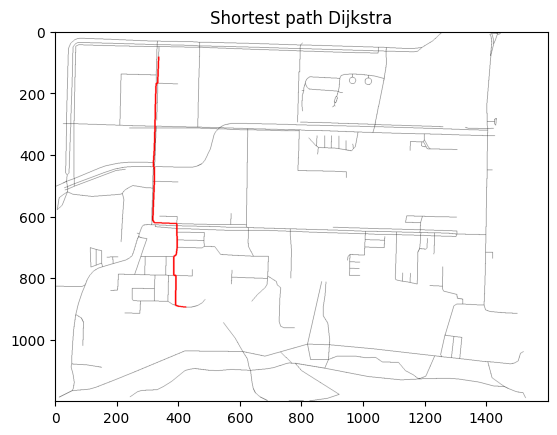

In [8]:
start=56
destination=800
shortest_path_dijkstra('data/moulon.json', start, destination)

# 5. A* Utils

In [9]:
def heuristique(json_graph,x:int,y:int):
    """ Return the distance between x and y in graph based on the euclidian distance between the two nodes
    Coordonates of each nodes are vailable in the graph (networkx graph))"""
    latx,lonx=json_graph['nodes'][x]['lat'], json_graph['nodes'][x]['lon']
    laty,lony=json_graph['nodes'][y]['lat'], json_graph['nodes'][y]['lon']
    return geopy_distance([latx,lonx],[laty,lony]).km*1000

def find_expected_closest_node(unvisited_nodes: dict):
    """
    Return the node with the minimum distance from the unvisited_nodes dictionary.
    Parameters:
        unvisited_nodes (dict): A dictionary containing nodes as keys and their corresponding distances as values
    Returns:
        str: The node with the minimum distance.
    """
    nodes = list(unvisited_nodes.keys())
    distances = [unvisited_nodes[node][1] for node in nodes]
    index_of_min_distance = np.argmin(distances)
    return nodes[index_of_min_distance]

def reconstruct_path_A_star(visited_nodes:list,start:int,destination:int):
    """ Return the path from the source node to the destination node according to visited_nodes list """
    visited=[destination]
    parent=destination
    while parent != start and parent !='':
        parent=visited_nodes[parent][2]
        visited.append(parent)
    return visited[::-1]

# 6. A* Algorithm

In [10]:
def A_star(graph,json_graph,start,destination):
  """ Return the list of visited nodes using the A* algorithm"""
  visited = {}
  unvisited = {}
  tpsheuris = 0
  tpsmin = 0
  for nodes in neighbours(graph,start):
    unvisited[nodes] = [float('inf'), float('inf'), '']  #distance from start, estimated distance to destination, previous node
  unvisited[start]=[0,heuristique(json_graph,start,destination),'']

  while destination not in list(visited.keys()):
    t1=time()
    x= find_expected_closest_node(unvisited)
    tpsmin = time()-t1
  
    for y in neighbours(graph, x):
      
      if y not in visited and y in unvisited : 
        dist = find_distance(graph,x,y)
        if unvisited[y][0]>unvisited[x][0]+ dist :  #on met à jour les valeurs pour les voisins 
          tps1 = time()
          heur=heuristique(json_graph,y,destination)
          tpsheuris += time() - tps1
          unvisited[y][0] = unvisited[x][0]+ dist
          unvisited[y][1] = unvisited[x][0] + dist+ heur
          unvisited[y][2] = x

      if y not in visited and y not in unvisited:
        tps1 = time()
        heur=heuristique(json_graph,y,destination)
        tpsheuris += time() - tps1
        dist = find_distance(graph,x,y)
        unvisited[y] = [unvisited[x][0]+ dist,unvisited[x][0] +  dist+ heur,x]
        
    visited[x]=unvisited[x]
    del unvisited[x]
  # print(tpsheuris, tpsmin)
  return visited


# 7. Apply shortest path with A* Algo

preparing to draw graph...


100%|██████████| 1751/1751 [00:00<00:00, 10396.17it/s]


drawing...


100%|██████████| 31/31 [00:00<00:00, 30350.94it/s]


saving output file: last_plot_Astar.png


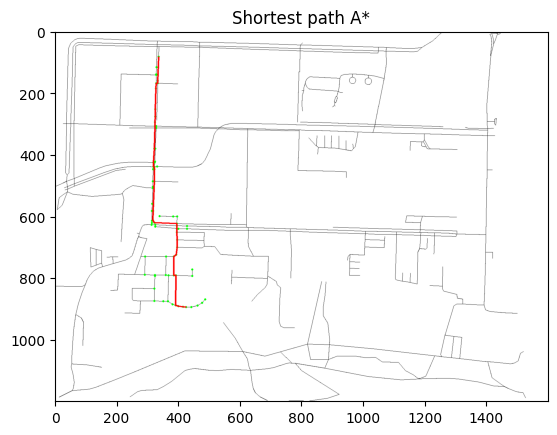

In [11]:
def shortest_path_A_star(graph_file:str='',start_point:int=0,destination:int=0,output_filename:str="last_plot_Astar.png",title:str='Shortest path A*'):
    """ Compute the shortest path from start_point to destination using A* algorithm and save the solution in a file"""
    graph,json_graph= load_graph(graph_file)
    visited_nodes = A_star(graph,json_graph,start_point,destination)
    path = reconstruct_path_A_star(visited_nodes, start,destination)
    draw_path= path_to_draw(path)
    draw_path_on_map(graph, draw_path, output_filename,title=title,visited=visited_nodes)
    return None
shortest_path_A_star('data/moulon.json',56,800)

# 8. Display Visited Nodes A* compared to Dijkstra

Dijkstra Algorithm is visiting all nodes in the graph, where A* Algorithm is trying to reduc the searching area using a heuristic function. Let's have a look at this : 
I collored in green the nodes visited by A* algorithm. User should remind that Dijkstra algorithm is visiting all nodes in the graphs.

preparing to draw graph...


100%|██████████| 1085551/1085551 [01:46<00:00, 10174.65it/s]


drawing...


100%|██████████| 591/591 [00:00<00:00, 478077.85it/s]


saving output file: last_plot_dijkstra_paris.png
Dijkstra time :  175.12458515167236
preparing to draw graph...


100%|██████████| 1085551/1085551 [01:52<00:00, 9674.59it/s] 


drawing...


100%|██████████| 591/591 [00:00<00:00, 1116089.00it/s]


saving output file: last_plot_Astar_paris.png
A* time :  223.8163046836853


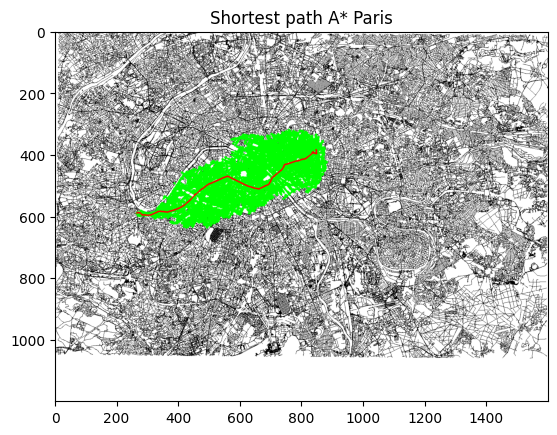

In [13]:
start_time = time()
shortest_path_dijkstra('data/Paris.json', 0, 8000, 'last_plot_dijkstra_paris.png','Shortest path Dijkstra Paris')
print("Dijkstra time : ", time() - start_time)

start_time = time()
shortest_path_A_star('data/Paris.json',0,8000,'last_plot_Astar_paris.png','Shortest path A* Paris')
print("A* time : ", time() - start_time)

On the previous plot we can clearly see how A* is limiting computation into the "most relevant direction". Most of time is actually lost computing the Heuristic in our code. 

# 9. About these algorithms

## Breadth-first search ( BFS )

BFS stands for Breadth-First Search. It is a simple graph traversal algorithm used to explore all the nodes or vertices of a graph in a breadth-first manner, starting from a specified source node. The algorithm visits all the nodes at the current depth level before moving on to nodes at the next depth level. 

This is the baseline for Dijkstra and A* algorithms. 

## What about the optimality ?

Dijkstra algorithm always return an optimall solution (one of / the shortest path possible)
A* algorithm is not necesarilly optimal. It's optimal if the heuristic function is admissible – meaning that it never overestimates the actual cost to get to the goal. In our case, the heuristic used is admissible.

# 10. Performance Analysis Dijkstra / A* / Python Librairies

This part was made in the initial project but I decided not to add it in my personal gitlab as I did not code it myself. I will love to explain anyone interested about it. 

# 11. Towards a more pleasant journey 

All cyclers know that all roads are not the same. Some of them are safer, others are prettier. At the end of the day we all have our own preferences. To take these preferences into account in our shortest path Algorithm, what we could do is update the lenghts in the graph so that algorithm will be more likely to select the roads of our interest.

The part bellow will define a dangerousness level for all roads and modify lengths in the graph according to this level.

In [14]:
def dangerosité (x,y,graph):
    dang_type = 1
    dang_speed = 1
    dang3=['primary','secondary','primary_link','secondary_link' ]
    dang2=['tertiary', 'tertiary_link', 'road', 'busway']
    if 'max_v' in graph[x][y] :
        if graph[x][y]['max_v']>60 : 
            dang_speed = 3
        elif 61> graph[x][y]['max_v']> 44 : 
            dang_speed = 2
    if 'highway' in graph[x][y] :
        if graph[x][y]['highway'] in dang3 : 
            dang_type = 3
        elif graph[x][y]['highway'] in dang2 :
            dang_type = 2
    return (max(dang_speed,dang_type))

def graph_ajust(graph) : 
    graph_ajust=graph
    for k in graph :
        for l in graph[k] :
            dang=dangerosité(k,l,graph) 
            if dang ==3 :
                graph_ajust[k][l]['length']=1.25*graph[k][l]['length']
            if dang ==2 :
                graph_ajust[k][l]['length']=1.12*graph[k][l]['length']
    return(graph_ajust)

graph_ajusted=graph_ajust(graph_final)

In [15]:
def shortest_path_dijkstra_ajusted(graph_file:str='',start_point: int = 0 , destination: int=0 , output_filename : str = "last_plot_dijkstra.png",title:str='Shortest path Dijkstra'):
    """ Compute the path from start_point to destination in graph with adjusted lengths and save the solution in a file"""
    graph,json_graph= load_graph(graph_file)
    graph_ajusted=graph_ajust(graph)
    parents = Dijkstra(graph_ajusted, start_point)
    path = path_to_destination(parents, destination)
    draw_path= path_to_draw(path)
    draw_path_on_map(graph, draw_path, output_filename,title=title)
    return None

Let's highlight the difference on a plot. Let's plot the shortest path computed by Dijkstra algorithm for a particular couple (Start Destination) first with the original graph and then with the adjusted graph. 

preparing to draw graph...


  0%|          | 0/1751 [00:00<?, ?it/s]

100%|██████████| 1751/1751 [00:00<00:00, 9036.21it/s]


drawing...


100%|██████████| 48/48 [00:00<?, ?it/s]


saving output file: last_plot_dijkstra_moulon.png


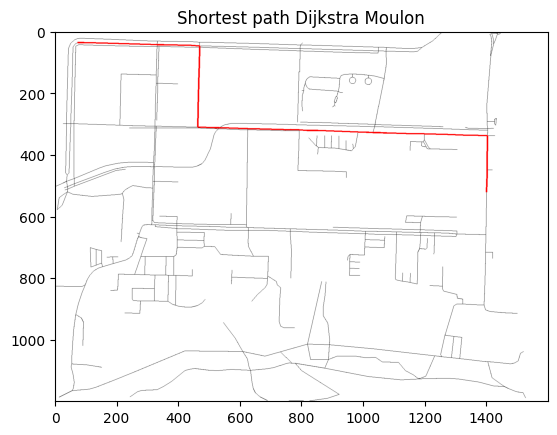

In [16]:
start=775
destination=834
# For the original graph
shortest_path_dijkstra('data/moulon.json', start, destination,'last_plot_dijkstra_moulon.png','Shortest path Dijkstra Moulon')

preparing to draw graph...


100%|██████████| 1751/1751 [00:00<00:00, 7987.84it/s]


drawing...


100%|██████████| 42/42 [00:00<?, ?it/s]


saving output file: last_plot_dijkstra_ajusted_moulon.png


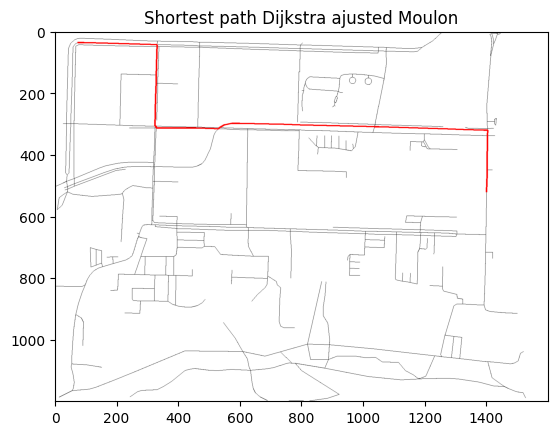

In [17]:
# For the adjusted graph
shortest_path_dijkstra_ajusted('data/moulon.json', start, destination,'last_plot_dijkstra_ajusted_moulon.png','Shortest path Dijkstra ajusted Moulon')

Note that during the long straight line in the middle, the shortest path method performed on the adjusted graph selects the road that goes up to the north and runs parallel to the base road returned in the original case. The reason for this is that the road selected in the 2nd case is a cycle path, unlike the previous one, which is designed for cars and buses. Therefore, a cyclist has a greater interest in using this parallel road as it is much safer and more pleasant to ride on, even though this path is almost as short as the first one.

In this case, we demonstrate that recomputing lengths in the original graph can make a lot of sense for developing user-specific shortest path solutions. The best approach to alter distances should obviously be discussed, which is not presented here.